# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 1           
model_seed = 1           

# --- Training configuration ---
save_epochs = [200, 400, 600, 800, 1000, 1200, 2000]

# --- Dataset configuration ---
base_data_size = (int)(0.33*9409)
dataset_type = "data"   
dataset_quantities = [0] # modulo arithmetic dataset sizes

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
import modulo_arithmetic_model_data as model_module
modulus = 97
# Generate dataset - for modulo arithmetic generates a large set
x_base, y_base, x_test, y_test = model_module.get_dataset(
    modulus = modulus,
    device = device,
)

# MNIST specific initialization parameters
hidden_dims = [250]

# Grab model
model_template = model_module.get_model(N = modulus, hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

# Assemble training dataset
# No additional data here! Just the base dataset.
additional_data = 0
x_train = x_base_train
y_train = y_base_train

# Initialize model (defined in the model-specific file)
torch.manual_seed(model_seed)
model = copy.deepcopy(model_template)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
batch_size = len(x_train)

# Initialize lists to accumulate metrics across all epochs
all_train_loss = []
all_test_loss = []
all_train_other_metrics = []  # Will store dicts for each epoch
all_test_other_metrics = []   # Will store dicts for each epoch

# Train model incrementally for each interval in save_epochs
previous_epoch = 0

for current_save_epoch in save_epochs:
    epochs_to_train = current_save_epoch - previous_epoch
    
    print(f"Training from epoch {previous_epoch} to {current_save_epoch} ({epochs_to_train} epochs)")
    
    # Train for the current interval
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model=model,
        x_train=x_train, y_train=y_train,
        x_test=x_test, y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics,
        optimizer=optimizer,
        epochs=epochs_to_train,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Append the new metrics to the accumulated lists
    all_train_loss.extend(train_loss)
    all_test_loss.extend(test_loss)
    all_train_other_metrics.extend(train_other_metrics)
    all_test_other_metrics.extend(test_other_metrics)
    
    # Build dictionary dynamically for additional metrics (for the entire training so far)
    train_metrics_dict = {}
    test_metrics_dict = {}
    
    if all_train_other_metrics and len(all_train_other_metrics) > 0:
        # Use keys from first available epoch dict
        for metric_name in all_train_other_metrics[0].keys():
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in all_train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in all_test_other_metrics]
    
    # Store results for current checkpoint
    trained_model = {
        "model": copy.deepcopy(model),  # Save a copy of the model at this checkpoint
        "train_loss": all_train_loss.copy(),  # Copy to avoid reference issues
        "test_loss": all_test_loss.copy(),
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        "total_epochs_trained": current_save_epoch,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)
    
    print(f"Completed training up to {current_save_epoch} epochs!")
    
    # Update previous epoch for next interval
    previous_epoch = current_save_epoch

# Free memory (important for large GPU datasets)
del x_train, y_train
torch.cuda.empty_cache()


Training from epoch 0 to 200 (200 epochs)
Epoch 1/200: Train Loss 0.0122 | Test Loss 0.0116 | accs Train 0.0106 Test 0.0105
Epoch 100/200: Train Loss 0.0089 | Test Loss 0.0105 | accs Train 0.8521 Test 0.2825
Epoch 200/200: Train Loss 0.0077 | Test Loss 0.0110 | accs Train 0.9630 Test 0.3198
Completed training up to 200 epochs!
Training from epoch 200 to 400 (200 epochs)
Epoch 1/200: Train Loss 0.0077 | Test Loss 0.0110 | accs Train 0.9636 Test 0.3204
Epoch 100/200: Train Loss 0.0070 | Test Loss 0.0113 | accs Train 0.9839 Test 0.3309
Epoch 200/200: Train Loss 0.0066 | Test Loss 0.0114 | accs Train 0.9919 Test 0.3382
Completed training up to 400 epochs!
Training from epoch 400 to 600 (200 epochs)
Epoch 1/200: Train Loss 0.0066 | Test Loss 0.0114 | accs Train 0.9913 Test 0.3384
Epoch 100/200: Train Loss 0.0063 | Test Loss 0.0114 | accs Train 0.9945 Test 0.3458
Epoch 200/200: Train Loss 0.0060 | Test Loss 0.0112 | accs Train 0.9958 Test 0.3598
Completed training up to 600 epochs!
Training 

Epoch 100/1000: Train Loss 0.1904 | Test Loss 1.2123 | accs Train 0.9000 Test 0.6130


Epoch 200/1000: Train Loss 0.0048 | Test Loss 3.6333 | accs Train 1.0000 Test 0.6172


Epoch 300/1000: Train Loss 0.0005 | Test Loss 4.2644 | accs Train 1.0000 Test 0.6195


Epoch 400/1000: Train Loss 0.0002 | Test Loss 4.5421 | accs Train 1.0000 Test 0.6190


Epoch 500/1000: Train Loss 0.0001 | Test Loss 4.7210 | accs Train 1.0000 Test 0.6188


Epoch 600/1000: Train Loss 0.0001 | Test Loss 4.8526 | accs Train 1.0000 Test 0.6180


Epoch 700/1000: Train Loss 0.0001 | Test Loss 4.9550 | accs Train 1.0000 Test 0.6185


Epoch 800/1000: Train Loss 0.0000 | Test Loss 5.0394 | accs Train 1.0000 Test 0.6190


Epoch 900/1000: Train Loss 0.0000 | Test Loss 5.1101 | accs Train 1.0000 Test 0.6185


Epoch 1000/1000: Train Loss 0.0000 | Test Loss 5.1699 | accs Train 1.0000 Test 0.6192
Completed training with 0 additional samples of data
Epoch 1/1000: Train Loss 0.6898 | Test Loss 0.6926 | accs Train 0.5600 Test 0.5000


Epoch 100/1000: Train Loss 0.3318 | Test Loss 0.9050 | accs Train 0.8400 Test 0.6255


Epoch 200/1000: Train Loss 0.1063 | Test Loss 2.5634 | accs Train 0.9400 Test 0.5935


Epoch 300/1000: Train Loss 0.0575 | Test Loss 3.4665 | accs Train 0.9800 Test 0.6360


Epoch 400/1000: Train Loss 0.0186 | Test Loss 4.4117 | accs Train 1.0000 Test 0.6565


Epoch 500/1000: Train Loss 0.0024 | Test Loss 5.4001 | accs Train 1.0000 Test 0.6765


Epoch 600/1000: Train Loss 0.0009 | Test Loss 5.7611 | accs Train 1.0000 Test 0.6870


Epoch 700/1000: Train Loss 0.0005 | Test Loss 5.9667 | accs Train 1.0000 Test 0.6923


Epoch 800/1000: Train Loss 0.0003 | Test Loss 6.1055 | accs Train 1.0000 Test 0.6970


Epoch 900/1000: Train Loss 0.0002 | Test Loss 6.2100 | accs Train 1.0000 Test 0.6997


Epoch 1000/1000: Train Loss 0.0002 | Test Loss 6.2990 | accs Train 1.0000 Test 0.7025
Completed training with 30 additional samples of data
Epoch 1/1000: Train Loss 0.6974 | Test Loss 0.6923 | accs Train 0.4750 Test 0.5000


Epoch 100/1000: Train Loss 0.4798 | Test Loss 0.6707 | accs Train 0.7083 Test 0.6270


Epoch 200/1000: Train Loss 0.2029 | Test Loss 0.7486 | accs Train 0.9083 Test 0.7582


Epoch 300/1000: Train Loss 0.0646 | Test Loss 0.7200 | accs Train 1.0000 Test 0.8720


Epoch 400/1000: Train Loss 0.0019 | Test Loss 0.7250 | accs Train 1.0000 Test 0.9133


Epoch 500/1000: Train Loss 0.0005 | Test Loss 0.7637 | accs Train 1.0000 Test 0.9163


Epoch 600/1000: Train Loss 0.0003 | Test Loss 0.7964 | accs Train 1.0000 Test 0.9177


Epoch 700/1000: Train Loss 0.0002 | Test Loss 0.8239 | accs Train 1.0000 Test 0.9183


Epoch 800/1000: Train Loss 0.0001 | Test Loss 0.8418 | accs Train 1.0000 Test 0.9193


Epoch 900/1000: Train Loss 0.0001 | Test Loss 0.8546 | accs Train 1.0000 Test 0.9197


Epoch 1000/1000: Train Loss 0.0001 | Test Loss 0.8645 | accs Train 1.0000 Test 0.9203
Completed training with 100 additional samples of data
Epoch 1/1000: Train Loss 0.6934 | Test Loss 0.6922 | accs Train 0.5125 Test 0.5000


Epoch 100/1000: Train Loss 0.5296 | Test Loss 0.5817 | accs Train 0.6750 Test 0.6488


Epoch 200/1000: Train Loss 0.0200 | Test Loss 0.0319 | accs Train 0.9969 Test 0.9912


Epoch 300/1000: Train Loss 0.0020 | Test Loss 0.0108 | accs Train 1.0000 Test 0.9965


Epoch 400/1000: Train Loss 0.0006 | Test Loss 0.0092 | accs Train 1.0000 Test 0.9970


Epoch 500/1000: Train Loss 0.0003 | Test Loss 0.0091 | accs Train 1.0000 Test 0.9970


Epoch 600/1000: Train Loss 0.0002 | Test Loss 0.0092 | accs Train 1.0000 Test 0.9972


Epoch 700/1000: Train Loss 0.0001 | Test Loss 0.0094 | accs Train 1.0000 Test 0.9972


Epoch 800/1000: Train Loss 0.0001 | Test Loss 0.0096 | accs Train 1.0000 Test 0.9975


Epoch 900/1000: Train Loss 0.0001 | Test Loss 0.0098 | accs Train 1.0000 Test 0.9972


Epoch 1000/1000: Train Loss 0.0000 | Test Loss 0.0100 | accs Train 1.0000 Test 0.9975
Completed training with 300 additional samples of data
Epoch 1/1000: Train Loss 0.6934 | Test Loss 0.6922 | accs Train 0.5125 Test 0.5000


Epoch 100/1000: Train Loss 0.5600 | Test Loss 0.5936 | accs Train 0.6861 Test 0.6567


Epoch 200/1000: Train Loss 0.0357 | Test Loss 0.0370 | accs Train 0.9903 Test 0.9918


Epoch 300/1000: Train Loss 0.0023 | Test Loss 0.0117 | accs Train 1.0000 Test 0.9958


Epoch 400/1000: Train Loss 0.0006 | Test Loss 0.0118 | accs Train 1.0000 Test 0.9962


Epoch 500/1000: Train Loss 0.0003 | Test Loss 0.0122 | accs Train 1.0000 Test 0.9968


Epoch 600/1000: Train Loss 0.0002 | Test Loss 0.0127 | accs Train 1.0000 Test 0.9968


Epoch 700/1000: Train Loss 0.0001 | Test Loss 0.0130 | accs Train 1.0000 Test 0.9968


Epoch 800/1000: Train Loss 0.0001 | Test Loss 0.0134 | accs Train 1.0000 Test 0.9968


Epoch 900/1000: Train Loss 0.0001 | Test Loss 0.0136 | accs Train 1.0000 Test 0.9968


Epoch 1000/1000: Train Loss 0.0000 | Test Loss 0.0139 | accs Train 1.0000 Test 0.9968
Completed training with 700 additional samples of data


## Training Summary

=== Last Model Data Keys ===
['model', 'train_loss', 'test_loss', 'additional_data', 'dataset_type', 'total_epochs_trained', 'train_accs', 'test_accs']

=== Model Info ===
Additional data: 0
Dataset type: data
Total epochs trained: 2000

=== Loss Statistics ===
Train loss length: 2000
Test loss length: 2000
Final train loss: 0.0038
Final test loss: 0.0074

=== Debug: Accuracy Keys ===
train_accuracy present? True
test_accuracy present? True


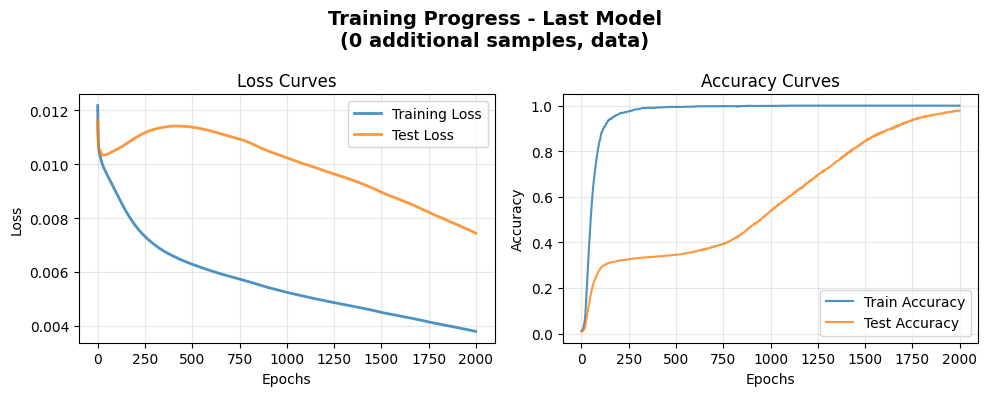


=== Final Metrics Summary ===
Metric               Training   Test       Gap       
--------------------------------------------------
Loss                 0.0038     0.0074     0.0036    
Accuracy             1.0000     0.9786     0.0214    


In [12]:
# ====================================
# Plotting for Last Model
# ====================================

# Get the last model from the list
last_model_data = all_models[-1]

print("=== Last Model Data Keys ===")
print(list(last_model_data.keys()))

print(f"\n=== Model Info ===")
print(f"Additional data: {last_model_data['additional_data']}")
print(f"Dataset type: {last_model_data['dataset_type']}")
print(f"Total epochs trained: {last_model_data.get('total_epochs_trained', 'Not specified')}")

print(f"\n=== Loss Statistics ===")
print(f"Train loss length: {len(last_model_data['train_loss'])}")
print(f"Test loss length: {len(last_model_data['test_loss'])}")
print(f"Final train loss: {last_model_data['train_loss'][-1]:.4f}")
print(f"Final test loss: {last_model_data['test_loss'][-1]:.4f}")

# --- Explicitly check if accuracy keys exist ---
has_train_acc = "train_accs" in last_model_data
has_test_acc = "test_accs" in last_model_data

print("\n=== Debug: Accuracy Keys ===")
print(f"train_accuracy present? {has_train_acc}")
print(f"test_accuracy present? {has_test_acc}")

# --- Create subplots: loss + accuracy (if available) ---
n_plots = 1 + (1 if has_train_acc or has_test_acc else 0)
n_cols = 2
n_rows = (n_plots + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

fig.suptitle(f'Training Progress - Last Model\n'
             f'({last_model_data["additional_data"]} additional samples, {last_model_data["dataset_type"]})',
             fontsize=14, fontweight='bold')
fig.suptitle(f'Training Progress - Last Model\n'
             f'({last_model_data["additional_data"]} additional samples, {last_model_data["dataset_type"]})',
             fontsize=14, fontweight='bold')

# --- Plot 1: Loss ---
ax_idx = 0
axes[ax_idx].plot(last_model_data["train_loss"], label='Training Loss', alpha=0.8, linewidth=2)
axes[ax_idx].plot(last_model_data["test_loss"], label='Test Loss', alpha=0.8, linewidth=2)
axes[ax_idx].set_xlabel('Epochs')
axes[ax_idx].set_ylabel('Loss')
axes[ax_idx].set_title('Loss Curves')
axes[ax_idx].legend()
axes[ax_idx].grid(True, alpha=0.3)

# --- Plot 2: Accuracy (if present) ---
if has_train_acc or has_test_acc:
    ax_idx += 1
    if has_train_acc:
        axes[ax_idx].plot(last_model_data["train_accs"], label='Train Accuracy', alpha=0.8)
    if has_test_acc:
        axes[ax_idx].plot(last_model_data["test_accs"], label='Test Accuracy', alpha=0.8)
    axes[ax_idx].set_xlabel('Epochs')
    axes[ax_idx].set_ylabel('Accuracy')
    axes[ax_idx].set_title('Accuracy Curves')
    axes[ax_idx].legend()
    axes[ax_idx].grid(True, alpha=0.3)

# Hide any unused subplots
for i in range(ax_idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# --- Print Final Summary ---
print(f"\n=== Final Metrics Summary ===")
print(f"{'Metric':<20} {'Training':<10} {'Test':<10} {'Gap':<10}")
print("-" * 50)
print(f"{'Loss':<20} {last_model_data['train_loss'][-1]:<10.4f} {last_model_data['test_loss'][-1]:<10.4f} "
      f"{abs(last_model_data['train_loss'][-1] - last_model_data['test_loss'][-1]):<10.4f}")

if has_train_acc and has_test_acc:
    gap = abs(last_model_data["train_accs"][-1] - last_model_data["test_accs"][-1])
    print(f"{'Accuracy':<20} {last_model_data['train_accs'][-1]:<10.4f} {last_model_data['test_accs'][-1]:<10.4f} {gap:<10.4f}")
elif has_train_acc:
    print(f"{'Accuracy':<20} {last_model_data['train_accs'][-1]:<10.4f} {'N/A':<10} {'N/A':<10}")
elif has_test_acc:
    print(f"{'Accuracy':<20} {'N/A':<10} {last_model_data['test_accs'][-1]:<10.4f} {'N/A':<10}")

## Model Saving

In [14]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_epoch_{model_data['total_epochs_trained']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
            total_epochs_trained=model_data["total_epochs_trained"]
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_epoch_200.pt
Saved model: models_and_data/model_epoch_200.pt
✅ Model saved to models_and_data\model_epoch_400.pt
Saved model: models_and_data/model_epoch_400.pt
✅ Model saved to models_and_data\model_epoch_600.pt
Saved model: models_and_data/model_epoch_600.pt
✅ Model saved to models_and_data\model_epoch_800.pt
Saved model: models_and_data/model_epoch_800.pt
✅ Model saved to models_and_data\model_epoch_1000.pt
Saved model: models_and_data/model_epoch_1000.pt
✅ Model saved to models_and_data\model_epoch_1200.pt
Saved model: models_and_data/model_epoch_1200.pt
✅ Model saved to models_and_data\model_epoch_2000.pt
Saved model: models_and_data/model_epoch_2000.pt
